# Set up environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import division
from __future__ import print_function

# Load scipy/numpy/matplotlib
from   scipy.linalg import expm
import matplotlib.pyplot as plt
from   pylab import *

# Configure figure resolution
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['savefig.dpi'   ] = 100

from izh       import * # Routines for sampling Izhikevich neurons
from plot      import * # Misc. plotting routines
from glm       import * # GLM fitting
from arppglm   import * # Sampling and integration
from utilities import * # Other utilities
from arguments import * # Argument verification

import numpy as np
import scipy.io

dtype = 'float64'

import os
flags = 'mode=FAST_RUN,device=gpu,floatX=%s'%dtype

#flags = 'mode=fast_compile,device=gpu,floatX=%s'%dtype
if dtype!='float64':
    flags += ',warn_float64=warn'
print(flags)
os.environ["THEANO_FLAGS"] = flags
import theano
import theano.tensor as T

from warnings import warn

from theano.compile.nanguardmode import NanGuardMode
NANGUARD = NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True)

print('Workspace Initialized')

mode=FAST_RUN,device=gpu,floatX=float64


1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33 //preprocessor macro 

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: cuda unavailable)



['nvcc', '-shared', '-O3', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden', '-Xlinker', '-rpath,/home/mrule/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/cuda_ndarray', '-I/usr/local/lib/python3.5/dist-packages/theano/sandbox/cuda', '-I/usr/local/lib/python3.5/dist-packages/numpy/core/include', '-I/usr/include/python3.5m', '-I/usr/local/lib/python3.5/dist-packages/theano/gof', '-L/usr/lib', '-o', '/home/mrule/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/cuda_ndarray/cuda_ndarray.so', 'mod.cu', '-lcublas', '-lpython3.5m', '-lcudart']
Workspace Initialized


### Theano helper functions

In [2]:
def Tcon(x):
    return T.constant(x,dtype=dtype)

eps     = 1e-4#Tcon(np.finfo('float32').eps)
max_exp = Tcon(4)#Tcon(np.log(np.sqrt(np.finfo('float32').max)))

def nozero(x):
    '''Clip number to be larger than `eps`'''
    return T.maximum(eps,x)
    #return T.log(1+T.exp(x*10))/10

def Tslog(x):
    '''Theano safe logarithm'''
    return T.log(nozero(x))

def Tsexp(x):
    return T.exp(T.minimum(max_exp,x))

def Tsinv(x):
    return 1.0/nozero(x)

def Tsdiv(a,x):
    return a/nozero(x)

def Tfun(inp=None,out=None,upd=None):
    return theano.function(inputs               = inp,
                           outputs              = out,
                           updates              = upd,
                           on_unused_input      = 'warn',
                           allow_input_downcast = True)
#,
 #                          mode                 = NANGUARD)
    
print('Theano helper functions defined')

Theano helper functions defined


### Load saved features for GLM

In [3]:
saved_training_model = scipy.io.loadmat('saved_training_model.mat')
K  = np.array(saved_training_model['K'],dtype=dtype)
B  = np.array(saved_training_model['B'],dtype=dtype)
By = np.array(saved_training_model['By'],dtype=dtype)
Bh = np.array(saved_training_model['Bh'],dtype=dtype)
A  = np.array(saved_training_model['A'],dtype=dtype)
C  = np.array(saved_training_model['C'],dtype=dtype)
Y  = np.array(saved_training_model['Y'],dtype=dtype)
dt = np.array(saved_training_model['dt'],dtype=dtype)

K  = int(scalar(K))
N  = prod(Y.shape)
Y  = np.squeeze(Y)
X  = concatenate([By,Bh],axis=1)

# Don't use all training data
'''N  = 3000
Y  = Y[:N]
By = By[:N]
Bh = Bh[:N]
X  = X[:N]'''

STARTPLOT = 2500
NPLOT = 3000
Y  = Y[STARTPLOT:STARTPLOT+NPLOT]
By = By[STARTPLOT:STARTPLOT+NPLOT]
Bh = Bh[STARTPLOT:STARTPLOT+NPLOT]
X  = X[STARTPLOT:STARTPLOT+NPLOT]

N = len(X)
STARTPLOT=0
NPLOT=N

print('Saved GLM features loaded')

Saved GLM features loaded


### Fit GLM on CPU and verify that filtering approximates basis functions

In [4]:
def lograte(p):
    '''
    Log-intensity of point process model on this dataset
    Predicted using the standard GLM way
    '''
    m       = array(p).ravel()[0]
    beta    = ascolumn(p[1:K+1])
    beta_st = ascolumn(p[1+K:])
    lograte = m + Bh.dot(beta_st) + By.dot(beta)
    return lograte

def logmean(M1,p):
    '''
    Projected history process
    Predicted using history-process means
    '''
    m       = array(p).ravel()[0]
    beta    = ascolumn(p[1:K+1])
    beta_st = ascolumn(p[1+K:])
    M1      = np.squeeze(M1)
    return (beta.T.dot(M1.T))[0] + (m + Bh.dot(beta_st))[:,0]

def get_stim(p):
    m        = array(p).ravel()[0]
    beta     = ascolumn(p[1:K+1])
    beta_st  = ascolumn(p[1+K:])
    stim     = (m + Bh.dot(beta_st))[:,0]
    return stim

def filter_GLM_np(p):
    m        = array(p).ravel()[0]
    beta     = ascolumn(p[1:K+1])
    beta_st  = ascolumn(p[1+K:])
    stim     = get_stim(p)
    allM1_np = np.zeros((N,K))
    M1       = np.zeros((K,1))
    for i in range(N):
        R   = sexp(p0[1:K+1].dot(M1)+m+stim[i])
        M1 += A.dot(M1)*dt + C.dot(R)
        allM1_np[i] = M1[:,0]
    return allM1_np

def addspikes():
    for t in find(Y>0):
        axvline(t,color=OCHRE,lw=0.4)
    
def niceaxis():
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore",message='No labelled objects found')
        legend()
    simpleraxis()
    xlim(STARTPLOT,STARTPLOT+NPLOT)
    addspikes()

print('GLM helpers done')

GLM helpers done


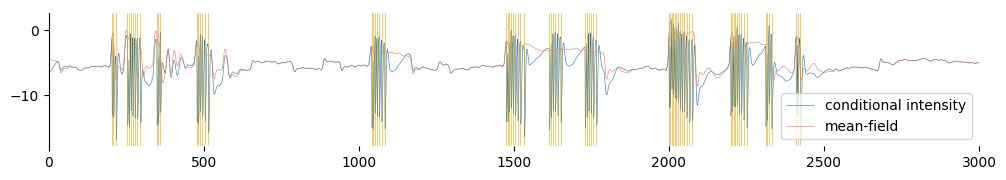

In [5]:
# Re-fit GLM
m,bhat  = fitGLM(X,Y)

# Re-pack model parameters
p0      = np.zeros((1+len(bhat)))
p0[0 ]  = m
p0[1:]  = bhat

allM1_np = filter_GLM_np(p0)

subplot(311)
plot(lograte(p0),lw=0.4,label='conditional intensity')
subplot(311)
plot(logmean(allM1_np,p0),lw=0.4,label='mean-field',color=RUST)
niceaxis()

# Filtering Langevin equation

Take the original process and add a likelihood potential

$$
dx = \left[ \mu(x,t) - \nabla \log P(y|x) \right] dt + \sigma(x,t) \cdot dW
$$

### First, illustrate Langevin sampling on Theano of the original point process

All the process noise comes from spiking, so for the single neuron case study we juts need a 1D sequence of random values. 

### Define Theano inputs and constants

In [6]:
# Input arguments
Xst  = T.matrix("Xst",dtype=dtype) # stimulus history features
Ysp  = T.vector("Ysp",dtype=dtype) # spikes
par  = T.vector("par",dtype=dtype) # packed parameter vectors

# Unpack parameter vector
b    = par[1:K+1] # spike history weights
bst  = par[K+1:]  # stimulus weights
mm   = par[0]     # constant offset

# Pre-compute projected stimulus
# This evaluates to a vector
stim = mm + Xst.dot(bst)

# Hard-coded parameters
oversample   = 4
dt           = 1.0
dtf          = dt/oversample
maxrate      = 5.0
maxlogr      = Tcon(log(maxrate*dt))
minlogr      = Tcon(log(sqrt(np.finfo('float32').tiny)*dt))
maxlogrf     = Tcon(log(maxrate*dtf))
minlogrf     = Tcon(log(sqrt(np.finfo('float32').tiny)*dtf))
#maxrate      = Tcon(maxrate)

# Cast system operators to theano matrices
Aop  = Tcon(A)
Cop  = Tcon(C)
Adtf = Tcon(A*dtf)
F    = T.slinalg.expm(Adtf)

print('Parameters and constants defined')

Parameters and constants defined


### Define random state

["a random variable is drawn at most once during any single function execution"](http://deeplearning.net/software/theano/tutorial/examples.html#using-random-numbers)

In [7]:
from theano.tensor.shared_randomstreams import RandomStreams
from theano import function
srng = RandomStreams(seed=234)
M = 200 # No. samples to draw
# NxM matrix of random numbers
G = srng.normal((N,oversample,M))
print('Random state defined')

Random state defined


### Define Theano Langevin sampler

In [8]:
def GLM_langevin(s,g,z):
    # M: No. samples
    # K: No. dimensions
    # s : scalar stimulus
    # g : M-vector of random numbers
    # z : list of column vectors, i.e. KxM  matrix
    for i in range(oversample):
        m  = b.T.dot(z)
        lr = s + m + T.log(dtf)
        lr = T.clip(lr,minlogrf,maxlogrf) # M-vector
        R0 = Tsexp(lr) # M-vector
        Y  = g[i]*T.sqrt(R0) + R0 # M-vector
        #z += Adtf.dot(z) # deterministic
        z = F.dot(z)
        z += Cop*(Y) # stochastic
    return z,lr # KxM  matrix

z0 = Tcon(np.zeros((K,M)))

[allz,alll], lup = theano.scan(GLM_langevin,
                            sequences     = [stim,G],
                            outputs_info  = [z0,None],
                            non_sequences = [],
                            n_steps       = N,
                            name          = 'GLM_langevin')

# GLM negative log-likelihood and history means
langevin_GLM = Tfun(inp = [Xst,par],
                  out = [allz,alll],
                  upd = lup)

print('Theano Langevin sampler defined')

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Theano Langevin sampler defined


### Compare theano sampler to CPU sampler

timing...
dt=392ms 
t=392ms 
dt=273ms 


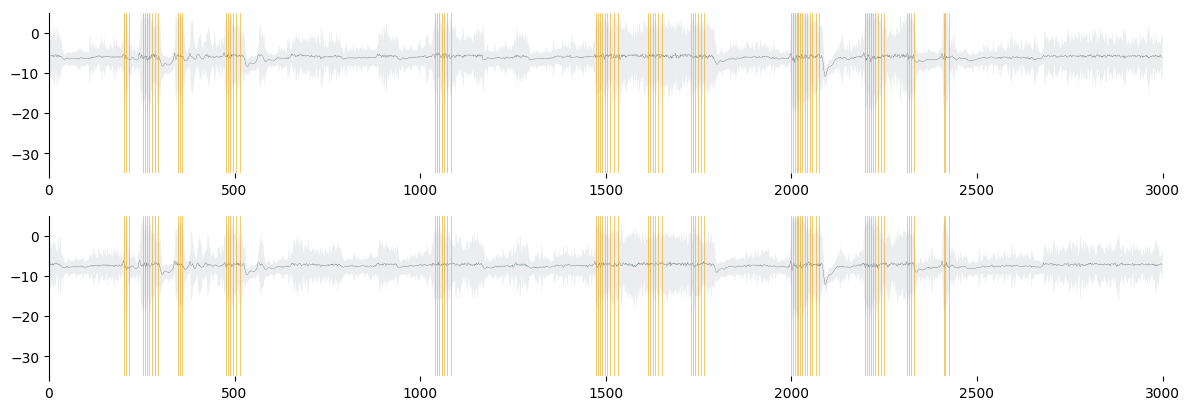

In [9]:
from arppglm import langevin_sample_history

p = p0.copy()

# Sample using Numpy
tic()
stim_np = get_stim(p)
beta_np = ascolumn(p[1:K+1])
allZ_np,allL_np = langevin_sample_history(stim_np,A,beta_np,C,
                    dt         = dt,
                    M          = M,
                    maxrate    = maxrate,
                    oversample = oversample) 
toc()

# Sample using Theano
tic()
allZ_th,allL_th = langevin_GLM(Bh,p)
toc()

subplot(311)
#plot(allL_np,lw=0.1,color=BLACK);
stderrplot(mean(allL_np,1),var(allL_np,1),color=BLACK,lw=0.2)
niceaxis()
ylim(-35,5)
subplot(312)
#plot(allL_th,lw=0.1,color=BLACK);
stderrplot(mean(allL_th,1),var(allL_th,1),color=BLACK,lw=0.2)
niceaxis()
ylim(-35,5)
tight_layout()

### Incorporate potential

$$
\nabla \log p(y|x) = \nabla[ y \log \lambda - \lambda]
= (y - \lambda) z
$$

In [10]:
reg_cov = 0.01

def GLM_potential(s,y,g,z):
    # M: No. samples
    # K: No. dimensions
    # s : scalar stimulus
    # g : M-vector of random numbers
    # z : list of column vectors, i.e. KxM  matrix
    for i in range(oversample):
        m  = b.T.dot(z)
        lr = s + m + T.log(dtf)
        lr = T.clip(lr,minlogrf,maxlogrf) # M-vector
        R0 = Tsexp(lr) # M-vector
        Y  = g[i]*T.sqrt(R0) + R0 # M-vector
        z  = F.dot(z)
        z += Cop*Y
        # potential terms
        z += (y*dtf-R0)*z
    m  = b.T.dot(z)
    lr = s + m + T.log(dt)
    lr = T.clip(lr,minlogr,maxlogr) # M-vector
    return z,lr # KxM  matrix

z0 = Tcon(np.zeros((K,M)))

[allzp,alllp], pup = theano.scan(GLM_potential,
                            sequences     = [stim,Ysp,G],
                            outputs_info  = [z0,None],
                            non_sequences = [],
                            n_steps       = N,
                            name          = 'GLM_potential')

# GLM negative log-likelihood and history means
potential_GLM = Tfun(inp = [Xst,Ysp,par],
                  out = [allzp,alllp],
                  upd = pup)

print('Theano Langevin potential sampler defined')

Theano Langevin potential sampler defined


t=1507ms 
dt=5779ms 
t=5888ms 
dt=306ms 


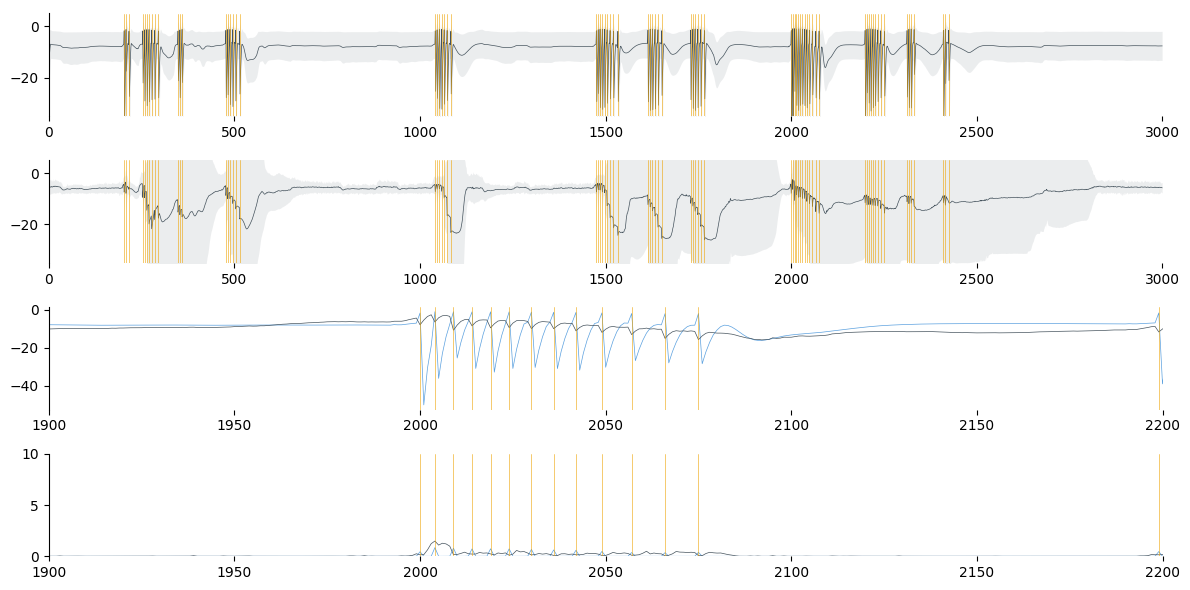

In [11]:
p = p0.copy()

# Sample using Numpy moment closure
subplot(411)
tic()
allLR,allLV,allM1,allM2,nll = filter_moments(stim_np,Y,A,beta_np,C,p[0],
    dt          = dt,
    oversample  = oversample,
    maxrate     = maxrate,
    maxvcorr    = 100,
    method      = "moment_closure",
    int_method  = "exponential",
    measurement = "moment",
    reg_cov     = 0.01,
    reg_rate    = 1e-3)
toc()
stderrplot(allLR,allLV,color=BLACK,lw=0.5)
niceaxis()
ylim(-35,5)

# Sample using Theano
subplot(412)
tic()
allZ_th,allL_th = potential_GLM(Bh,Y,p)
toc()
stderrplot(mean(allL_th,1),var(allL_th,1),color=BLACK,lw=0.5)
niceaxis()
ylim(-35,5)

subplot(413)
plot(allLR,lw=0.5,color=AZURE)
plot(mean(allL_th,1),lw=0.5,color=BLACK)
niceaxis()
xlim(1900,2200)

subplot(414)
plot(exp(allLR)*(1+0.5*allLV),lw=0.5,color=AZURE)
plot(mean(exp(allL_th),1),lw=0.5,color=BLACK)
niceaxis()
ylim(0,10)
xlim(1900,2200)

tight_layout()

### So

Langevin with likelihood potential smoothes out fast timescales, but more or less is OK

In [12]:
print('Mean rate         ',mean(Y))
print('Mean rate langevin',mean(exp(allL_th)))
print('Mean rate moments ',mean(exp(allLR)*(1+0.5*allLV)))

Mean rate          0.0253333333333
Mean rate langevin 0.0396951805533
Mean rate moments  0.0160521068534


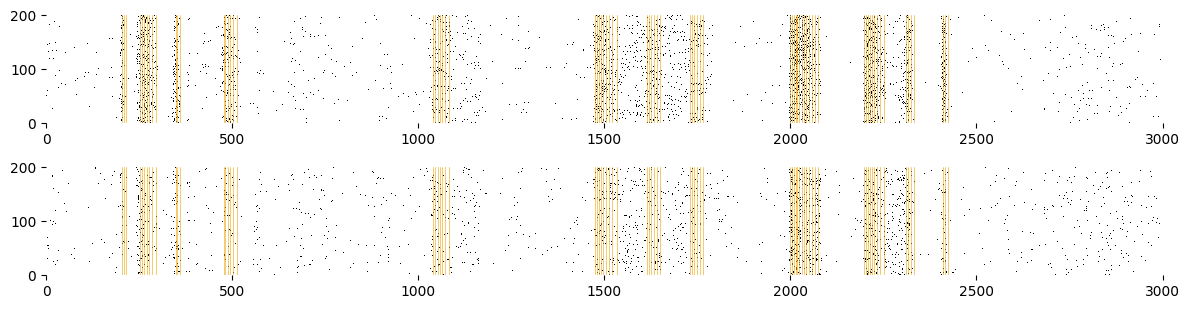

In [13]:
y1,l1 = ensemble_sample(stim_np,B,beta_np,M)
y2 = np.random.poisson(exp(allL_th))

subplot(411)
pcolormesh(-int32(y1.T>0),cmap='gray')
noaxis()
niceaxis()

subplot(412)
pcolormesh(-int32(y2.T>0),cmap='gray')
niceaxis()
noaxis()

tight_layout()

# Likelihood

In [21]:

'''
srng = RandomStreams(seed=234)
M = 200 # No. samples to draw
# NxM matrix of random numbers
G = srng.normal((N,oversample,M))
'''

G = Tcon(np.random.randn(N,oversample,M))

def GLM_langevin_likelihood(s,y,g,nll,z):
    # M: No. samples
    # K: No. dimensions
    # s : scalar stimulus
    # g : M-vector of random numbers
    # z : list of column vectors, i.e. KxM  matrix
    ll = 0
    dy = y*dtf
    for i in range(oversample):
        m  = b.T.dot(z)
        lr = s + m + T.log(dtf)
        lr = T.minimum(lr,maxlogrf)
        #lr = T.clip(lr,minlogrf,maxlogrf) # M-vector
        R0 = Tsexp(lr) # M-vector
        ll+= T.mean(dy*lr - R0)
        Y  = g[i]*T.sqrt(R0) + R0 # M-vector
        z  = F.dot(z)
        z += Cop*Y
    m  = b.T.dot(z)
    lr = s + m + T.log(dt)
    lr = T.clip(lr,minlogr,maxlogr) # M-vector
    return nll-ll,z,lr # KxM  matrix

z0 = Tcon(np.zeros((K,M)))
[CNLLLV,allzvl,alllvl], puvl = theano.scan(GLM_langevin_likelihood,
                            sequences     = [stim,Ysp,G],
                            outputs_info  = [Tcon(0),z0,None],
                            non_sequences = [],
                            n_steps       = N,
                            name          = 'GLM_langevin_likelihood')
NLLLV = CNLLLV[-1]
# GLM negative log-likelihood and history means
NLL_GLM_LV = Tfun(inp = [Xst,Ysp,par],
                  out = [NLLLV,allzvl,alllvl],
                  upd = puvl)

print('Theano Langevin potential likelihood defined')

Theano Langevin potential likelihood defined


In [23]:
p1 = p0.copy() + randn(*p0.shape)*1e-6
#p1[1:K+1] *= 0.125
nllv,_,_ = NLL_GLM_LV(Bh,Y,p1)
print(nllv)
result_LV = p1

655.1145143034637


In [26]:
verbose = False
large   = sqrt(np.finfo('float32').max)
def objective_LV(p):
    nllv,_,_ = NLL_GLM_LV(Bh,Y,p)
    nll = nllv
    if verbose:
        print('x=',v2str_long(p))
        print('nll =',np.float128(nll).astype(str))
    if not isfinite(nll):
        nll = large
    return nll

print('Starting optimization')
result_LV = minimize_retry(objective_LV,result_LV,jac=False,verbose=verbose,simplex_only=True,tol=1e-12)
print("Finished optimization")
print('x=','['+','.join([np.float128(x).astype(str) for x in result_LV])+']')
print("Total absolute change from GLM fit is",sum(abs(result_LV-p0)))

Starting optimization

                                                                                 
Finished optimization
x= [-5.42954568378,1.55676559331,-3.96649367884,1.38376817933,1.37945171576,-4.06009447459,3.87539441682,-2.41921085743,0.784024586612,1.04762701197,-1.20735810796,1.57058490095,-0.846836248702,0.56922284025,-0.289197091893,0.0800184808253,-0.0342798046334]
Total absolute change from GLM fit is 34.7892303906


### Compare

Sampling from GLMfit and the new optimization

t=556811ms 
dt=302ms 
t=387ms 
dt=294ms 


(-35, 5)

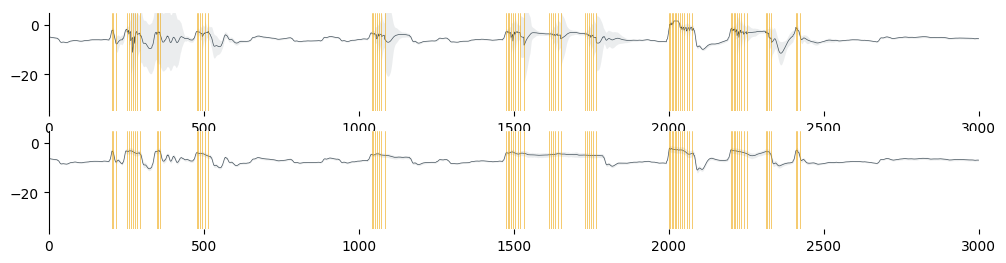

In [27]:
# Sample using Theano
subplot(411)
tic()
allZ_th,allL_th = potential_GLM(Bh,Y,result_LV)
toc()
stderrplot(mean(allL_th,1),var(allL_th,1),color=BLACK,lw=0.5)
niceaxis()
ylim(-35,5)
# Sample using Theano
subplot(412)
tic()
allZ_th,allL_th = langevin_GLM(Bh,result_LV)
toc()
stderrplot(mean(allL_th,1),var(allL_th,1),color=BLACK,lw=0.5)
niceaxis()
ylim(-35,5)
tight_layout()

figure()
y1,l1 = ensemble_sample(stim_np,B,beta_np,M)
subplot(411)
pcolormesh(-int32(y1.T>0),cmap='gray')
noaxis()
niceaxis()
stim2_np = get_stim(result_LV)
beta2_np = result_LV[1:K+1]
y2,l2 = ensemble_sample(stim2_np,B,beta2_np,M)
subplot(412)
pcolormesh(-int32(y2.T>0),cmap='gray')
noaxis()
niceaxis()
tight_layout()

In [29]:
reg_cov = 0.01

def GLM_potential_likelihood(s,y,g,nll,z):
    # M: No. samples
    # K: No. dimensions
    # s : scalar stimulus
    # g : M-vector of random numbers
    # z : list of column vectors, i.e. KxM  matrix
    ll = 0
    dy = y*dtf
    for i in range(oversample):
        m  = b.T.dot(z)
        lr = s + m + T.log(dtf)
        lr = T.clip(lr,minlogrf,maxlogrf) # M-vector
        R0 = Tsexp(lr) # M-vector
        ll+= T.mean(dy*lr - R0)
        Y  = g[i]*T.sqrt(R0) + R0 # M-vector
        z  = F.dot(z)
        z += Cop*Y
        z += (dy-R0)*z
    m  = b.T.dot(z)
    lr = s + m + T.log(dt)
    lr = T.clip(lr,minlogr,maxlogr) # M-vector
    return nll-ll,z,lr # KxM  matrix

z0 = Tcon(np.zeros((K,M)))
[CNLLLP,allzpl,alllpl], pupl = theano.scan(GLM_potential_likelihood,
                            sequences     = [stim,Ysp,G],
                            outputs_info  = [Tcon(0),z0,None],
                            non_sequences = [],
                            n_steps       = N,
                            name          = 'GLM_potential_likelihood')
NLLLP = CNLLLP[-1]
# GLM negative log-likelihood and history means
NLL_GLM_LP = Tfun(inp = [Xst,Ysp,par],
                  out = [NLLLP,allzpl,alllpl],
                  upd = pupl)

print('Theano Langevin potential likelihood defined')

Theano Langevin potential likelihood defined


In [31]:
result_LP = result_LV.copy()

In [ ]:
verbose = False
large   = sqrt(np.finfo('float32').max)
def objective_LP(p):
    nllp,_,_ = NLL_GLM_LP(Bh,Y,p)
    nllv,_,_ = NLL_GLM_LV(Bh,Y,p)
    nll = nllp + nllv
    if verbose:
        print('x=',v2str_long(p))
        print('nll =',np.float128(nll).astype(str))
    if not isfinite(nll):
        nll = large
    return nll

print('Starting optimization')
result_LP = minimize_retry(objective_LP,result_LP,jac=False,verbose=verbose,simplex_only=True,tol=1e-12)
print("Finished optimization")
print('x=','['+','.join([np.float128(x).astype(str) for x in result_LV])+']')
print("Total absolute change from GLM fit is",sum(abs(result_LV-p0)))

Starting optimization

No. function evals    566 	No. grad evals      0 	Best value 772.247406183       

t=179207ms 
dt=306ms 
t=392ms 
dt=212ms 
Mean rate          0.0253333333333
Mean rate GLMfit   0.0246483333333
Mean rate LVfit    0.02517


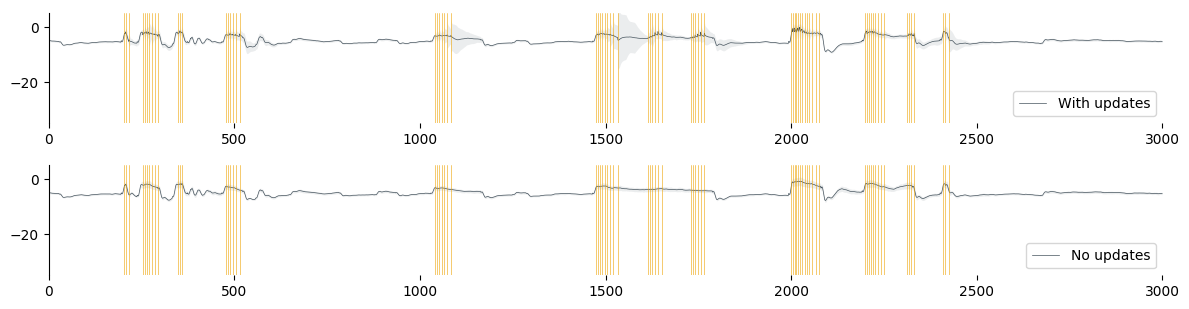

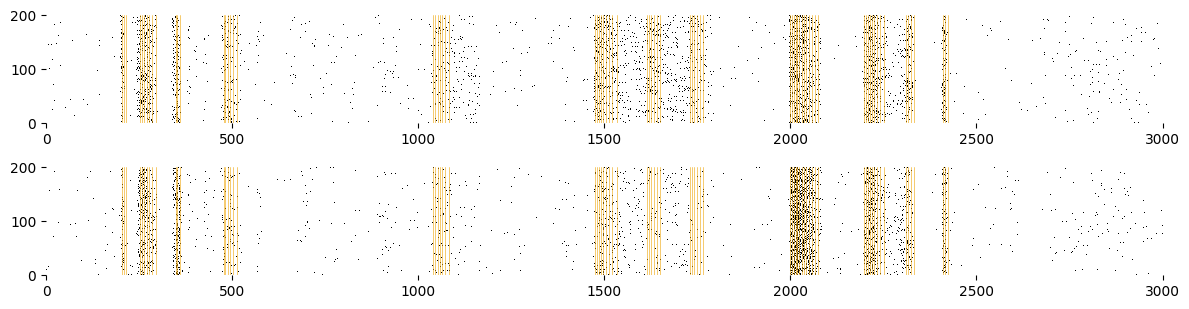

In [40]:
# Sample using Theano
subplot(411)
tic()
allZ_th,allL_th = potential_GLM(Bh,Y,result_LP)
toc()
stderrplot(mean(allL_th,1),var(allL_th,1),color=BLACK,lw=0.5,label='With updates')
niceaxis()
ylim(-35,5)
# Sample using Theano
subplot(412)
tic()
nllv,allZ_th,allL_th = NLL_GLM_LV(Bh,Y,result_LP)
#allZ_th,allL_th = langevin_GLM(Bh,result_LV)
toc()
stderrplot(mean(allL_th,1),var(allL_th,1),color=BLACK,lw=0.5,label='No updates')
niceaxis()
ylim(-35,5)
tight_layout()

figure()
y1,l1 = ensemble_sample(stim_np,B,beta_np,M)
subplot(411)
pcolormesh(-int32(y1.T>0),cmap='gray')
noaxis()
niceaxis()
stim2_np = get_stim(result_LP)
beta2_np = result_LP[1:K+1]
y2,l2 = ensemble_sample(stim2_np,B,beta2_np,M)
subplot(412)
pcolormesh(-int32(y2.T>0),cmap='gray')
noaxis()
niceaxis()
tight_layout()

print('Mean rate         ',mean(Y))
print('Mean rate GLMfit  ',mean(y1))
print('Mean rate LVfit   ',mean(y2))